**UNIVERSIDADE FEDERAL DO ABC - UFABC**

*CECS - Centro de Engenharia, Modelagem e Ciências Sociais Aplicadas*

*Programa de Pós-Graduação em Engenharia da Informação*

*INF317G - Inteligência Artificial Baseada em Evidências*


```
Profª Drª Priscyla Waleska Simões

Discentes:
*   Emanuel Cleyton Macedo Lemos
*   João Antonio Marques Costa





---
[*TRIPOD*] Título

# Desenvolvimento de um Modelo Preditivo para Classificar o Grau de Agressividade do Tumor Ósseo em Pacientes do Centro de Câncer *Memorial Sloan Kettering*

---



[*TRIPOD*] Introdução - Antecedentes e objetivos

## INTRODUÇÃO



*   Um dos tipos de câncer menos frequente
*   Prognóstico depende de diferentes fatores:
 *   tipo, localização, idade, estado geral, tratamento e resposta, entre outros
* Tipos de tumores ósseos:
 * Osteossarcoma ([mais frequente](https://www.cancer.org/cancer/types/bone-cancer/about/key-statistics.html))
    * se inicia nas células ósseas
    * se desenvolve com mais frequência nos ossos dos braços, pernas e pelve
 * Condrossarcoma
    * se desenvolve nas células que forma a cartilagem
 * Tumores de Ewing
    * raro em adultos com mais de 30 anos
    * locais mais frequentes são a pelve, parede torácica e ossos das pernas ou braços
 * Outros tipos: cordomas, sarcoma pleomófico indiferenciado de alto grau, fribrossarcoma, ...




## Informação dos Dados


[*TRIPOD*] Métodos - Fonte de dados
*   Dados para aplicação dos algoritmos de ML obtidos no Kaggle:
  * [Bone Tumor](https://www.kaggle.com/datasets/antimoni/bone-tumor)
  * Autor: Prathap Kumar

[*TRIPOD*] Métodos - Participantes
* Origem dos dados:
  * Dados coletados do Centro de Câncer Memorial Sloan Kettering ([MSKCC](https://www.mskcc.org/)), Estados Unidos
  * Pacientes que foram diagnósticados com tumor ósseo entre 2010 e 2020
  * Fontes: registros médicos, triagens clínicas, pesquisas com pacientes
* Tratamento de dados pré-disponibilização pública:
  * Dados anonimizados
  * Dados limpados e verificados para garantir confiabilidade e precisão

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from tqdm.notebook import tqdm
from warnings import filterwarnings

# Fonte dos dados originais no Kaggle: https://www.kaggle.com/datasets/antimoni/bone-tumor
# o link abaixo foi obtido de repositório no GitHub: https://github.com/badcodepratices/Bone-Tumor-DataAnalysis
filename = 'https://raw.githubusercontent.com/badcodepratices/Bone-Tumor-DataAnalysis/main/Bone%20Tumor%20Dataset.csv'

data = pd.read_csv(filename)
data.head()

,Patient ID,Sex,Age,Grade,Histological type,MSKCC type,Site of primary STS,"Status (NED, AWD, D)",Treatment
0,STS_022,Female,63,High,pleiomorphic leiomyosarcoma,Leiomyosarcoma,parascapusular,NED,Radiotherapy + Surgery
1,STS_034,Female,54,Intermediate,pleiomorphic leiomyosarcoma,MFH,left thigh,D,Surgery + Chemotherapy
2,STS_022,Male,22,Intermediate,synovial sarcoma,MFH,right buttock,D,Radiotherapy + Surgery
3,STS_015,Female,54,Intermediate,synovial sarcoma,Leiomyosarcoma,right thigh,NED,Radiotherapy + Surgery
4,STS_037,Male,63,High,pleiomorphic spindle cell undifferentiated,MFH,right parascapusular,AWD,Radiotherapy + Surgery + Chemotherapy


In [ ]:
# Remoção da coluna Patient ID que não será utilizado para o treinamento do classificador
total_pop = len(data['Patient ID'])
data.drop('Patient ID', axis=1, inplace=True)

[*TRIPOD*] Métodos - Tamanho da amostra

Lista de categorias x quantidade de registros para cada atributo presente na base de dados

In [ ]:
print("RESUMO DE DADOS")
print("População (total de registros): {}\n\n".format(total_pop))
for col in data.columns:
  print("="*60)
  print(data[col].value_counts())

RESUMO DE DADOS
População (total de registros): 500


Female    300
Male      200
Name: Sex, dtype: int64
63    17
41    17
72    17
45    16
66    16
      ..
23     1
19     1
26     1
29     1
27     1
Name: Age, Length: 65, dtype: int64
Intermediate    282
High            218
Name: Grade, dtype: int64
pleiomorphic leiomyosarcoma                   104
synovial sarcoma                               73
leiomyosarcoma                                 43
myxofibrosarcoma                               40
undifferentiated - pleiomorphic                34
sclerosing epithelioid fibrosarcoma            33
pleiomorphic spindle cell undifferentiated     29
malignant solitary fibrous tumor               29
undifferentiated pleomorphic liposarcoma       28
myxoid fibrosarcoma                            27
poorly differentiated synovial sarcoma         24
pleomorphic sarcoma                            21
epithelioid sarcoma                            15
Name: Histological type, dtype: int64
MFH  

[*TRIPOD*] Métodos - Dados ausentes

(não há dados ausentes)

In [ ]:
# verificando se existem dados nulos
data.isnull().sum()

Sex                     0
Age                     0
Grade                   0
Histological type       0
MSKCC type              0
Site of primary STS     0
Status (NED, AWD, D)    0
Treatment               0
dtype: int64

## OBJETIVO

O objetivo geral desta implementação foi verificar se os classificadores propostos conseguem acertar o grau do tumor com base nos outros atributos presentes na base de dados. Ou seja, o algoritmo deve apresentar o quão agressivo é o câncer, considerando duas classes: intermediária e alta.

### Grau do tumor x Status

O estado do paciente é categorizado como:

*   NED - sem evidência da doença
*   AWD - vivo com a doença
*   D - morto

O código abaixo mostra:
1. dados de distribuição do Grau do tumor x Status x Quantidade de casos
2. agrupa a quantidade de de D + AWD como categoria única
3. matriz de distribuição



Grade         Status (NED, AWD, D)
High          AWD                      90
              D                        59
              NED                      69
Intermediate  AWD                      22
              D                        82
              NED                     178
Name: Status (NED, AWD, D), dtype: int64

[[149 104]
 [ 69 178]]


Text(0.5, 0, 'Grau')

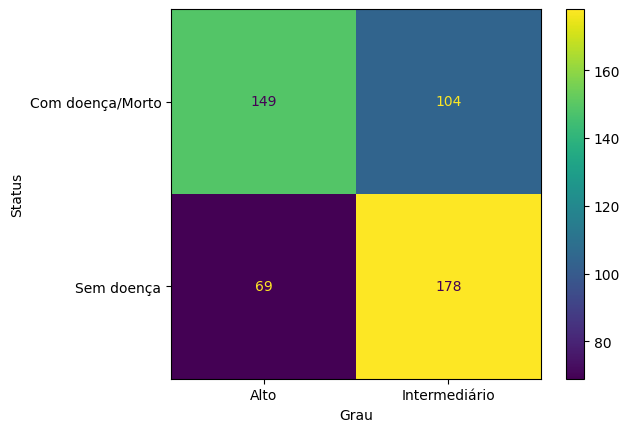

In [ ]:
dados = data.groupby(['Grade','Status (NED, AWD, D)'])['Status (NED, AWD, D)'].count()
print(dados, end='\n\n')

doente_morto = [dados.High.D + dados.High.AWD,
                dados.Intermediate.D + dados.Intermediate.AWD]
sem_doenca = [dados.High.NED, dados.Intermediate.NED]
todos_casos = np.array([doente_morto, sem_doenca])
print(todos_casos)

metrics.ConfusionMatrixDisplay(todos_casos,
                               display_labels=['Alto','Intermediário']
                               ).plot()
plt.yticks(ticks=[0,1], labels=['Com doença/Morto', 'Sem doença'])
plt.ylabel(ylabel='Status')
plt.xlabel(xlabel='Grau')

Métricas baseadas na matriz: Grau x Status

In [ ]:
alto_doenca, interm_doenca, alto_sem_doenca, interm_sem_doenca = todos_casos.ravel()

incidencia_doenca = alto_doenca / (alto_doenca + interm_doenca)
incidencia_sem_doenca = alto_sem_doenca / (alto_sem_doenca + interm_sem_doenca)
risco_relativo = incidencia_doenca / incidencia_sem_doenca

odds_ratio = (alto_doenca * interm_sem_doenca) / (alto_sem_doenca * interm_doenca)


print("Incidência de casos Graves sem evidência da doença: {:.2f}".format(incidencia_sem_doenca))
print("Incidência de casos Graves com doença ou morte: {:.2f}".format(incidencia_doenca))
# risco relativo de que casos graves apresentem
# status de presença da doença ou morte
print("Risco relativo: {:.2f}".format(risco_relativo))

print("Odds Ratio: {:.2f}".format(odds_ratio))


Incidência de casos Graves sem evidência da doença: 0.28
Incidência de casos Graves com doença ou morte: 0.59
Risco relativo: 2.11
Odds Ratio: 3.70


## MÉTODOS



Os próximos passos seguidos foram:

1. Pré-processamento dos dados
> 1. Codificação dos dados
> 2. Seleção do atributo de classe
> 3. Seleção dos conjuntos de treino e de teste

2. Criação dos modelos de aprendizagem de máquina
> 1. Seleção de 3 técnicas (KNN, Árvore de decisão, Regras de Bayes)
> 2. Verificação automática do melhor modelo e seus parâmetros

3. Avaliação dos modelos
> 1. Geração de métricas gerais
> 2. Geração de outras métricas de avaliação do melhor modelo

### [Pré-processamento]

Codifica em categorias numéricas para ajuste do classificador

In [ ]:
le = LabelEncoder()
data = data.apply(le.fit_transform)

data.head()

,Sex,Age,Grade,Histological type,MSKCC type,Site of primary STS,"Status (NED, AWD, D)",Treatment
0,0,44,0,5,0,3,2,0
1,0,35,1,5,1,2,1,2
2,1,4,1,10,1,4,1,0
3,0,35,1,10,0,6,2,0
4,1,44,0,6,1,5,0,1


Divide os dados em X (atributos/features) e Y (classe)

In [ ]:
Y = data['Grade']
X = data.drop('Grade', axis=1)

In [ ]:
Y.unique()
# 0 - High
# 1 - Intermediate

array([0, 1])

[*TRIPOD*] Resultados - Participantes

Divisão dos dados em dois conjuntos: treino (70%) e teste (30%)

In [ ]:
# separa dados em conjunto de treino e teste

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=7)

In [ ]:
print('Treino: ',len(y_train))
print('Teste: ',len(y_test))

Treino:  350
Teste:  150


Plota gráfico de distribuição dos dados conforme a classe para cada conjunto (treino e teste)

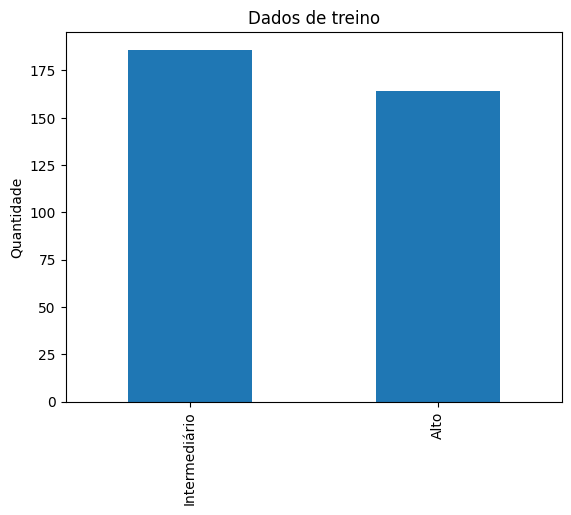

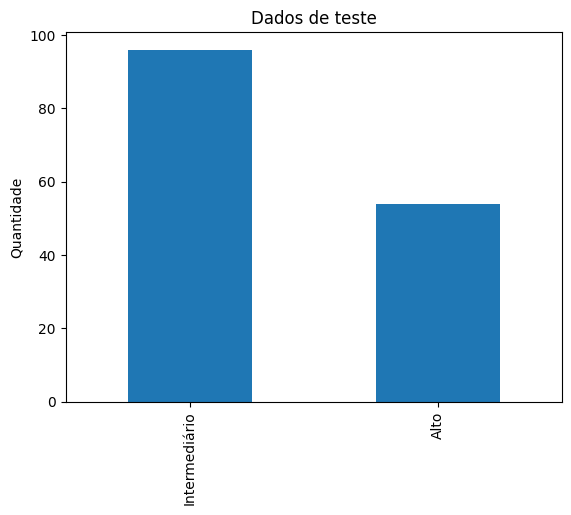

In [ ]:
# distribuição dos dados nos conjuntos de treino e teste
def gera_graficos(conjunto, titulo):
  cont = conjunto.value_counts()
  grade = pd.DataFrame(data=np.array(cont), index=['Intermediário', 'Alto'])

  grade.plot(kind='bar', title=titulo,
             ylabel='Quantidade', legend=False)

gera_graficos(y_train, 'Dados de treino')
gera_graficos(y_test, 'Dados de teste')

### [Criação do modelo]

As técnicas de aprendizagem de máquina selecionados para verificar os melhores ajustes foram:

* Árvore de decisão:
  * método de aprendizagem supervisionada
  * cada nó da árvore é um ponto de decisão que leva a um ramo, dependendo do resultado
  * utiliza métodos como entropia e índice gini para verificar atributos com melhor ganho de informação, colocando em nós no topo da árvore

* K-vizinhos mais próximos:
  * classifica cada registro avaliando a sua distância em relação aos vizinhos mais próximos (no caso deste estudo, k=2)
  * a classe da maioria dos vizinhos define a classe do registro


* Regras de Bayes:
  * gera um conjunto de probabilidades aplicando o teorema de Bayes verificando as probabilidades de ocorrência ou não de uma classe
  * supõe independência condicional entre cada par de atributo

Seleção automática dos melhores parâmetros para cada modelo

[*TRIPOD*] Métodos - Métodos de análise estatística - 10a, 10b

[*TRIPOD*] Resultados - Desenvolvimento do modelo - 14a

[*TRIPOD*] Resultados - Especificação do modelo - 15a e 15b

In [ ]:

filterwarnings('ignore')

seed = 7

estimators = {'tree': DecisionTreeClassifier(),
              'knn': KNeighborsClassifier(),
              'bayes': CategoricalNB()
              }

params = {'tree': {'criterion': ['gini','entropy'],
                          'max_depth': range(3,10),
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'random_state': [seed]},
          'knn': {'n_neighbors': [2],
                  'algorithm': ['auto','ball_tree','kd_tree','brute'],
                  'weights': ['uniform','distance'],
                  'metric': ['euclidean', 'manhattan','minkowsk']},
          'bayes': {'alpha': [0.01, 0.1, 1.0, 10.0],
                    'force_alpha': [True]}
          }

best_values = dict()
for estimator in tqdm(estimators):
  grid = GridSearchCV(estimators[estimator], params[estimator])
  grid.fit(x_train, y_train)
  best_values[estimator] = {
      'best_estimator': grid.best_estimator_,
      'best_score': grid.best_score_,
      'best_params': grid.best_params_
  }

print('Melhores valores obtidos pelo ajuste automático: \n')
best_values

  0%|          | 0/3 [00:00<?, ?it/s]

Melhores valores obtidos pelo ajuste automático: 



{'tree': {'best_estimator': DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=7),
  'best_score': 0.7257142857142858,
  'best_params': {'criterion': 'gini',
   'max_depth': 5,
   'max_features': 'auto',
   'random_state': 7}},
 'knn': {'best_estimator': KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance'),
  'best_score': 0.6342857142857142,
  'best_params': {'algorithm': 'auto',
   'metric': 'manhattan',
   'n_neighbors': 2,
   'weights': 'distance'}},
 'bayes': {'best_estimator': CategoricalNB(alpha=10.0, force_alpha=True),
  'best_score': 0.74,
  'best_params': {'alpha': 10.0, 'force_alpha': True}}}

## RESULTADOS

### [Avaliação dos modelos]

[*TRIPOD*] Métodos - Métodos de análise estatística - 10c, 10d

[*TRIPOD*] Resultados - Especificação do modelo - 15b

Verificação dos modelos para cada melhor configuração de parâmetro após ajuste automático

São geradas algumas métricas para comparação dos modelos construídos: [*TRIPOD*] - item 16
* Acurácia
* Área da Curva ROC (e gráfico)
* Matriz de confusão


Tipo do Classificador: <class 'sklearn.tree._classes.DecisionTreeClassifier'>

--- Métricas de avaliação ----
Acurácia: 79.33 %
Area da Curva ROC: 0.7737268518518519

Validação cruzada :
col_0   0   1
Grade        
0      38  16
1      15  81

              precision    recall  f1-score   support

           0       0.72      0.70      0.71        54
           1       0.84      0.84      0.84        96

    accuracy                           0.79       150
   macro avg       0.78      0.77      0.77       150
weighted avg       0.79      0.79      0.79       150


Tipo do Classificador: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>

--- Métricas de avaliação ----
Acurácia: 68.00 %
Area da Curva ROC: 0.697337962962963

Validação cruzada :
col_0   0   1
Grade        
0      41  13
1      35  61

              precision    recall  f1-score   support

           0       0.54      0.76      0.63        54
           1       0.82      0.64      0.72        96

    accura

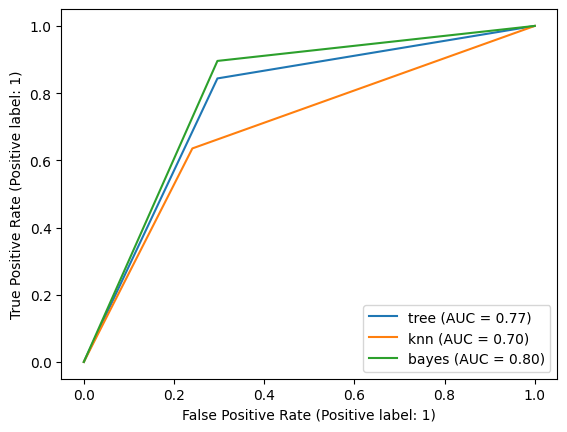

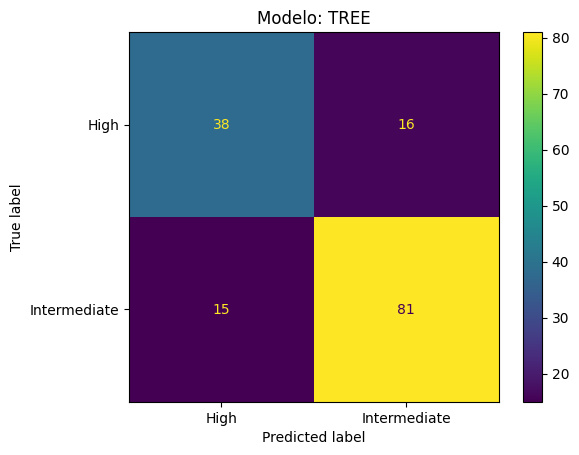

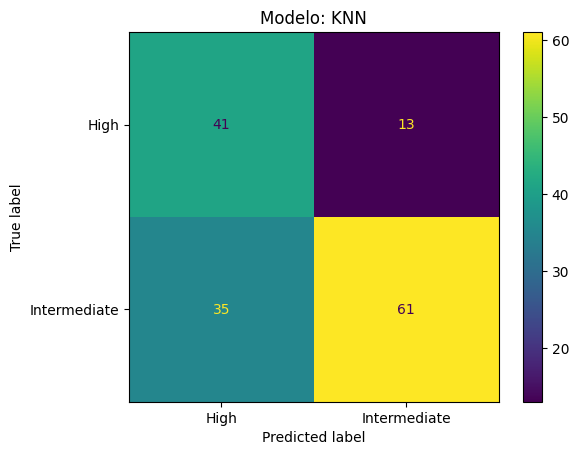

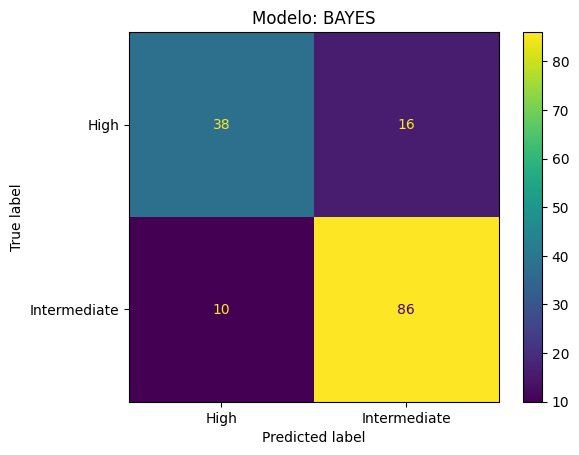

In [ ]:
ax1 = plt.axes()

model, clf = dict(), dict()

for key, values in best_values.items():
  model[key] = estimators[key].set_params(**values['best_params'])
  clf[key] = model[key].fit(x_train, y_train)
  y_pred = clf[key].predict(x_test)

  print('\nTipo do Classificador: {}\n'.format(type(model[key])))

  print("--- Métricas de avaliação ----")
  print("Acurácia: {:.2f} %".format(metrics.accuracy_score(y_test, y_pred) * 100))
  print('Area da Curva ROC: {}'.format(metrics.roc_auc_score(y_test, y_pred)))

  print('\nValidação cruzada :')
  print(pd.crosstab(y_test, y_pred))

  print()
  print(metrics.classification_report(y_test, y_pred))

  cf_matrix = metrics.confusion_matrix(y_test, y_pred)

  cm_display = metrics.ConfusionMatrixDisplay(cf_matrix,
                                              display_labels=['High','Intermediate'])
  cm_display.plot()
  cm_display.ax_.set_title(label='Modelo: '+key.upper())

  metrics.RocCurveDisplay.from_predictions(y_true=y_test,
                                           y_pred=y_pred,
                                           ax=ax1, name=key)

  print('='*60)

plt.show()


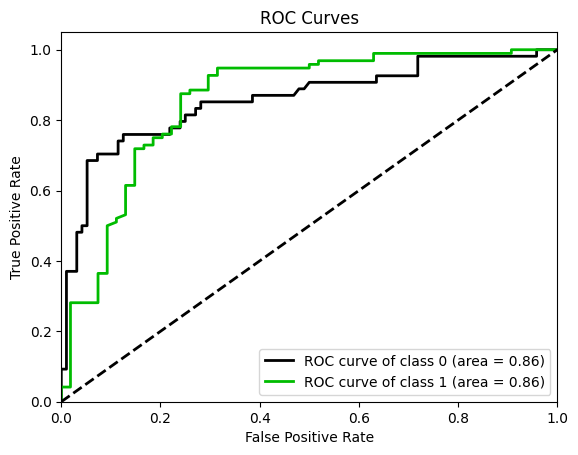

In [ ]:
import scikitplot as skplt

# Estimativas de probabilidade de retorno para o vetor de features do conjunto de teste
y_probas = clf['bayes'].predict_proba(x_test)

skplt.metrics.plot_roc_curve(y_test, y_probas, curves='each_class')
plt.show()

[*TRIPOD*] Resultados - Desempenho do modelo - item 16

Evidências geradas a partir do melhor modelo

In [ ]:
tn, fp, fn, tp = cf_matrix.ravel()

print("Resumo de métricas de avaliação para o melhor resultado")
print("Modelo gerado pelo classificador CategoricalNB\n")

pop = tn + fp + fn + tp
print(f"Quantidade de casos de teste para avaliar algoritmo: {pop}\n")

acc = (tp + tn)/pop
tpr_sensitivity = tp / (tp + fn)
fnr = fn / (tp + fn)
fpr = fp / (fp + tn)
tnr_specificity = tn / (fp + tn)
prevalence = (tp + fn) / pop
precision = tp / (tp + fp)
for_omission_rate = fn / (fn + tn)
fdr = fp / (tp + fp)
npv = tn / (fn + tn)

pos_LR = tpr_sensitivity / (1 - tnr_specificity)
neg_LR = (1 - tpr_sensitivity) / tnr_specificity

print("Acurácia: {:.2f}".format(acc))
print("Taxa de verdadeiro positivo | recall | sensibilidade: {:.2f}".format(tpr_sensitivity))
print("Taxa de falso negativo (taxa de erros da IA): {:.2f}".format(fnr))
print("Taxa de falso positivo (probabilidade de alarme falso): {:.2f}".format(fpr))
print("Taxa de verdadeiro negativo | especificidade: {:.2f}".format(tnr_specificity))
print("Prevalencia: {:.2f}".format(prevalence))
print("Precisão | Valor preditivo verdadeiro: {:.2f}".format(precision))
print("Taxa de falsa omissão: {:.2f}".format(for_omission_rate))
print("Taxa de verossimilhança positiva: {:.2f}".format(pos_LR))
print("Taxa de verossimilhança negativa: {:.2f}".format(neg_LR))
print("Taxa de descoberta falsa: {:.2f}".format(fdr))
print("Valor preditivo negativo: {:.2f}".format(npv))

dor = pos_LR / neg_LR
print("\nDiagnostic Odds Ratio: {:.2f}".format(dor))


Resumo de métricas de avaliação para o melhor resultado
Modelo gerado pelo classificador CategoricalNB

Quantidade de casos de teste para avaliar algoritmo: 150

Acurácia: 0.83
Taxa de verdadeiro positivo | recall | sensibilidade: 0.90
Taxa de falso negativo (taxa de erros da IA): 0.10
Taxa de falso positivo (probabilidade de alarme falso): 0.30
Taxa de verdadeiro negativo | especificidade: 0.70
Prevalencia: 0.64
Precisão | Valor preditivo verdadeiro: 0.84
Taxa de falsa omissão: 0.21
Taxa de verossimilhança positiva: 3.02
Taxa de verossimilhança negativa: 0.15
Taxa de descoberta falsa: 0.16
Valor preditivo negativo: 0.79

Diagnostic Odds Ratio: 20.43


Intervalo de confiança (95%)

In [ ]:
ci_menos, ci_mais = st.t.interval(confidence=0.95, df=len(y_test)-1,
              loc=np.mean(y_test), scale=st.sem(y_test))

print(f'Intervalo de confiança: [{ci_menos}, {ci_mais}]')

Intervalo de confiança: [0.5622969726149908, 0.7177030273850092]


## DISCUSSÃO



*   Melhor modelo: CategoricalNB (Naive Bayes)

[*TRIPOD*] Discussão - Interpretação - item 19a
*   Evidências para cada 100 pacientes:
  * o classificador acerta mais para casos com grau de alta agressividade do tumor:
     * 90 são classificadas corretamente com grau alto
     * 70 são classificadas com grau intermediário
  * a probabilidade de classificar um paciente com grau de alta agressividade do tumor quando o caso seria de grau intermediário é de 3.02

[*TRIPOD*] Discussão - Implicações - item 20
* Implicações:
  * o modelo tem potencial para sugerir casos de maior agressividade do tumor como uma 'segunda opinião' ao médico especialista visando sugerir casos que necessitem de uma investigação mais aprofundada e acompanhamento

[*TRIPOD*] Discussão - Limitações - item 18
* Limitações:
  * dados contém apenas casos em que houve a presença da doença, classificando em dois níveis de agressividade
  





---

## Referências

[1] Sharma A, Yadav DP, Garg H, Kumar M, Sharma B, Koundal D. Bone Cancer Detection Using Feature
Extraction Based Machine Learning Model. Comput Math Methods Med. 2021 Dec 20;2021:7433186. doi:
10.1155/2021/7433186. PMID: 34966444; PMCID: PMC8712164.


[2] von Schacky CE, Wilhelm NJ, Schäfer VS, Leonhardt Y, Jung M, Jungmann PM, Russe MF, Foreman SC,
Gassert FG, Gassert FT, Schwaiger BJ, Mogler C, Knebel C, von Eisenhart-Rothe R, Makowski MR, Woertler
K, Burgkart R, Gersing AS. Development and evaluation of machine learning models based on X-ray
radiomics for the classification and differentiation of malignant and benign bone tumors. Eur Radiol. 2022
Sep;32(9):6247-6257. doi: 10.1007/s00330-022-08764-w. Epub 2022 Apr 9. PMID: 35396665; PMCID:
PMC9381439.


[3] Kumar, Narinder & Gupta, Bhawna. (2016). Global incidence of primary malignant bone tumors. Current
Orthopaedic Practice. 27. 530-534.


[4] Prathap Kumar. Bone Tumor. Disponível em: https://www.kaggle.com/datasets/antimoni/bone-tumor. Acessado em: nov/2023